In [2]:
import pandas as pd
import numpy as np
import re
olympic_data=pd.read_csv('athlete_events.csv')

In [3]:
#Number of countries and athletes participating is inconsistent before 1996 - use only data post 1996
condition_year_1996=olympic_data["Year"]>=1996
olympic_data=olympic_data[condition_year_1996]
condition_summer=olympic_data["Season"]=="Summer"
olympic_data=olympic_data[condition_summer]

In [4]:
# Create a mapping dictionary for corrections
# Replace incorrect names with correct ones

corrections = {
    "Athina": "Athens",
    "Roma": "Rome",
    "Moskva": "Moscow",
    "Sankt Moritz": "St. Moritz"
}


olympic_data['City'] = olympic_data['City'].replace(corrections)

In [5]:
#Investigating quality of ID column
#Duplicates exist but this is intentional, as one athlete can participate in more than one event/olympics.
#ID numbering is consistent throughout years - e.g. same ID for athlete in different olympic games.
#ID is based on alphabetical order of last name
#no missing values in the ID column
#Team column comments: Team names are inconsistent - mixed with countries and sports team names. We will use NOC column instead for our analysis

In [6]:
#Replace Na values as "No Medal" string as null values correspond to no winning athletes.
olympic_data["Medal"] = olympic_data["Medal"].apply(lambda x:"No Medal" if pd.isna(x) else x)

In [7]:
#The difference between the medal count can be due to differences on the number of team sport members and ties.
olympic_data["Medal"].value_counts()

Medal
No Medal    69395
Bronze       4078
Gold         3903
Silver       3878
Name: count, dtype: int64

In [8]:
olympic_data.drop_duplicates(inplace = True)
print(olympic_data.duplicated().sum())

0


In [9]:
#NOC column - we want to merge the NOC column in our Olympics dataset with the region column from the NOC regions dataset
noc_regions = pd.read_csv('noc_regions.csv')

#Merge the datasets on the 'NOC' column
olympic_data = pd.merge(
    olympic_data, 
    noc_regions[['NOC', 'region']], 
    on='NOC', 
    how='left'
)

olympic_data = olympic_data.rename(columns={'region': 'Region'})

In [10]:
# Aggregate Olympic data to calculate: Every combination of 'Year', 'NOC', and 'City' is unique. 
# Medal counts (Gold, Silver, Bronze, No Medal) grouped by Year, NOC, and City.
# To calculate the medal performance (efficiency factor), we count the total number of athletes who won medals, instead of counting the number of medals. This is because in team events, multiple athletes contribute to the win, so it’s more accurate to focus on the athletes who played a role in the victory.

medal_data = olympic_data.groupby(['Year', 'NOC', 'City', 'Region']).agg(
    Athlete_Count=('ID', 'nunique'),  # Count unique athlete IDs
    Athlete_Gold_Count=('Medal', lambda x: (x == 'Gold').sum()),
    Athlete_Silver_Count=('Medal', lambda x: (x == 'Silver').sum()),
    Athlete_Bronze_Count=('Medal', lambda x: (x == 'Bronze').sum()),
    Athlete_N_Count=('Medal', lambda x: (x == 'No Medal').sum())
).reset_index()

# Add a new column to calculate the total number of medals
medal_data['Athlete_Medal_Count'] = (
    medal_data['Athlete_Gold_Count'] + 
    medal_data['Athlete_Silver_Count'] + 
    medal_data['Athlete_Bronze_Count']
)

# Calculate Medal_Performance: total medals / Athlete_Count
medal_data['Medal_Total_Performance'] = (medal_data['Athlete_Medal_Count'] / medal_data['Athlete_Count']).round(2)
medal_data['Medal_Gold_Performance'] = (medal_data['Athlete_Gold_Count'] / medal_data['Athlete_Count']).round(2)


medal_data

,Year,NOC,City,Region,Athlete_Count,Athlete_Gold_Count,Athlete_Silver_Count,Athlete_Bronze_Count,Athlete_N_Count,Athlete_Medal_Count,Medal_Total_Performance,Medal_Gold_Performance
0,1996,AFG,Atlanta,Afghanistan,2,0,0,0,2,0,0.00,0.00
1,1996,AHO,Atlanta,Curacao,6,0,0,0,7,0,0.00,0.00
2,1996,ALB,Atlanta,Albania,7,0,0,0,9,0,0.00,0.00
3,1996,ALG,Atlanta,Algeria,45,2,0,1,44,3,0.07,0.04
4,1996,AND,Atlanta,Andorra,8,0,0,0,8,0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1199,2016,VIE,Rio de Janeiro,Vietnam,22,1,1,0,26,2,0.09,0.05
1200,2016,VIN,Rio de Janeiro,Saint Vincent,4,0,0,0,4,0,0.00,0.00
1201,2016,YEM,Rio de Janeiro,Yemen,3,0,0,0,3,0,0.00,0.00
1202,2016,ZAM,Rio de Janeiro,Zambia,7,0,0,0,7,0,0.00,0.00


In [11]:
# Ranking the NOCs within each Year based on Medal_Performance (highest first)
medal_data['Rank'] = medal_data.groupby('Year')['Medal_Total_Performance'].rank(method='first', ascending=False)

# Filter the top 5 NOCs per year
top_5_per_year = medal_data[medal_data['Rank'] <= 5]

# Select only the relevant columns
top_5_per_year = top_5_per_year[['Year', 'NOC', 'Region', 'City', 'Athlete_Count', 'Athlete_Medal_Count', 'Medal_Gold_Performance', 'Medal_Total_Performance', 'Rank']]

top_5_per_year

,Year,NOC,Region,City,Athlete_Count,Athlete_Medal_Count,Medal_Gold_Performance,Medal_Total_Performance,Rank
39,1996,CHN,China,Atlanta,294,106,0.06,0.36,4.0
93,1996,JAM,Jamaica,Atlanta,46,16,0.02,0.35,5.0
132,1996,NGR,Nigeria,Atlanta,65,24,0.26,0.37,3.0
155,1996,SCG,Serbia,Atlanta,68,26,0.01,0.38,2.0
187,1996,USA,USA,Atlanta,648,259,0.25,0.40,1.0
209,2000,BAH,Bahamas,Sydney,25,11,0.24,0.44,4.0
236,2000,CMR,Cameroon,Sydney,34,18,0.53,0.53,1.0
291,2000,JAM,Jamaica,Sydney,48,23,0.00,0.48,2.0
332,2000,NOR,Norway,Sydney,93,43,0.22,0.46,3.0
351,2000,RUS,Russia,Sydney,435,187,0.15,0.43,5.0


In [12]:
brazil = medal_data[medal_data['Region'] == 'Brazil']
brazil

,Year,NOC,City,Region,Athlete_Count,Athlete_Gold_Count,Athlete_Silver_Count,Athlete_Bronze_Count,Athlete_N_Count,Athlete_Medal_Count,Medal_Total_Performance,Medal_Gold_Performance,Rank
27,1996,BRA,Atlanta,Brazil,221,5,15,43,188,63,0.29,0.02,11.0
222,2000,BRA,Sydney,Brazil,198,0,12,36,188,48,0.24,0.00,21.0
422,2004,BRA,Athens,Brazil,243,18,19,3,278,40,0.16,0.07,30.0
622,2008,BRA,Beijing,Brazil,268,14,34,30,260,78,0.29,0.05,11.0
823,2012,BRA,London,Brazil,248,14,34,11,247,59,0.24,0.06,15.0
1026,2016,BRA,Rio de Janeiro,Brazil,462,36,8,6,533,50,0.11,0.08,50.0


In [13]:
uk = medal_data[medal_data['Region'] == 'UK']
uk

,Year,NOC,City,Region,Athlete_Count,Athlete_Gold_Count,Athlete_Silver_Count,Athlete_Bronze_Count,Athlete_N_Count,Athlete_Medal_Count,Medal_Total_Performance,Medal_Gold_Performance,Rank
67,1996,GBR,Atlanta,UK,300,2,15,9,365,26,0.09,0.01,50.0
264,2000,GBR,Sydney,UK,310,22,20,12,361,54,0.17,0.07,26.0
463,2004,GBR,Athens,UK,264,17,25,15,303,57,0.22,0.06,20.0
663,2008,GBR,Beijing,UK,304,31,25,25,339,81,0.27,0.10,16.0
865,2012,GBR,London,UK,530,48,30,48,558,126,0.24,0.09,16.0
1068,2016,GBR,Rio de Janeiro,UK,360,64,55,26,333,145,0.40,0.18,4.0


In [14]:
greece = medal_data[medal_data['Region'] == 'Greece']
greece

,Year,NOC,City,Region,Athlete_Count,Athlete_Gold_Count,Athlete_Silver_Count,Athlete_Bronze_Count,Athlete_N_Count,Athlete_Medal_Count,Medal_Total_Performance,Medal_Gold_Performance,Rank
73,1996,GRE,Atlanta,Greece,121,4,4,0,172,8,0.07,0.03,56.0
270,2000,GRE,Sydney,Greece,140,4,6,8,157,18,0.13,0.03,37.0
469,2004,GRE,Athens,Greece,426,8,18,5,468,31,0.07,0.02,51.0
669,2008,GRE,Beijing,Greece,152,0,3,4,169,7,0.05,0.00,66.0
871,2012,GRE,London,Greece,102,0,0,3,112,3,0.03,0.00,79.0
1074,2016,GRE,Rio de Janeiro,Greece,92,3,1,3,97,7,0.08,0.03,60.0


In [15]:
aus = medal_data[medal_data['Region'] == 'Australia']
aus

,Year,NOC,City,Region,Athlete_Count,Athlete_Gold_Count,Athlete_Silver_Count,Athlete_Bronze_Count,Athlete_N_Count,Athlete_Medal_Count,Medal_Total_Performance,Medal_Gold_Performance,Rank
11,1996,AUS,Atlanta,Australia,417,32,16,84,418,132,0.32,0.08,9.0
206,2000,AUS,Sydney,Australia,617,60,69,54,605,183,0.30,0.10,11.0
406,2004,AUS,Athens,Australia,470,49,77,31,444,157,0.33,0.10,8.0
606,2008,AUS,Beijing,Australia,432,31,42,76,421,149,0.34,0.07,4.0
807,2012,AUS,London,Australia,405,18,37,59,400,114,0.28,0.04,10.0
1010,2016,AUS,Rio de Janeiro,Australia,420,23,34,25,436,82,0.20,0.05,22.0


In [16]:
medal_data["City"].value_counts()

City
Rio de Janeiro    204
London            203
Beijing           202
Athens            200
Sydney            199
Atlanta           196
Name: count, dtype: int64

In [17]:
# Medal Conversion Rate on Host Country
# USA 1996, AUS 2000, GRE 2004, CHN 2008, GBR 2012, BRA 2016
# List of NOCs to filter
host_region_years = [
    ('Brazil', 2012, 2016),
    ('UK', 2008, 2012),
    ('China', 2004, 2008),
    ('Greece', 2000, 2004),
    ('Australia', 1996, 2000)
]

# Create an empty list to store processed data
host_data_list = []

for region, non_host_year, host_year in host_region_years:
    
    # Extract data for Non-Host Year
    non_host_df = medal_data[(medal_data['Region'] == region) & (medal_data['Year'] == non_host_year)]
    
    # Extract data for Host Year
    host_df = medal_data[(medal_data['Region'] == region) & (medal_data['Year'] == host_year)]
    
    # Get Medal_Total_Performance values
    non_host_performance = non_host_df['Medal_Total_Performance'].sum() if not non_host_df.empty else 0
    host_performance = host_df['Medal_Total_Performance'].sum() if not host_df.empty else 0
    
    # Convert to percentage
    non_host_percentage = round(non_host_performance * 100, 2)
    host_percentage = round(host_performance * 100, 2)
    change_pp = round(host_percentage - non_host_percentage, 2)
    
    # Append to list
    host_data_list.append({'Country (Host Year)': f'{region} ({host_year})', 
                           'Non-Host': f'{non_host_percentage}%', 
                           'Host': f'{host_percentage}%', 
                           'Change (pp)': f'{change_pp} pp'})

# Convert list to DataFrame
host_data_medal_rate = pd.DataFrame(host_data_list)

host_data_medal_rate

,Country (Host Year),Non-Host,Host,Change (pp)
0,Brazil (2016),24.0%,11.0%,-13.0 pp
1,UK (2012),27.0%,24.0%,-3.0 pp
2,China (2008),31.0%,31.0%,0.0 pp
3,Greece (2004),13.0%,7.0%,-6.0 pp
4,Australia (2000),32.0%,30.0%,-2.0 pp


/var/folders/yn/zzdysdkj6_z0rns53nqvdbvr0000gn/T/ipykernel_97465/2862523147.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Year'] = filtered_data['Year'].astype(str)


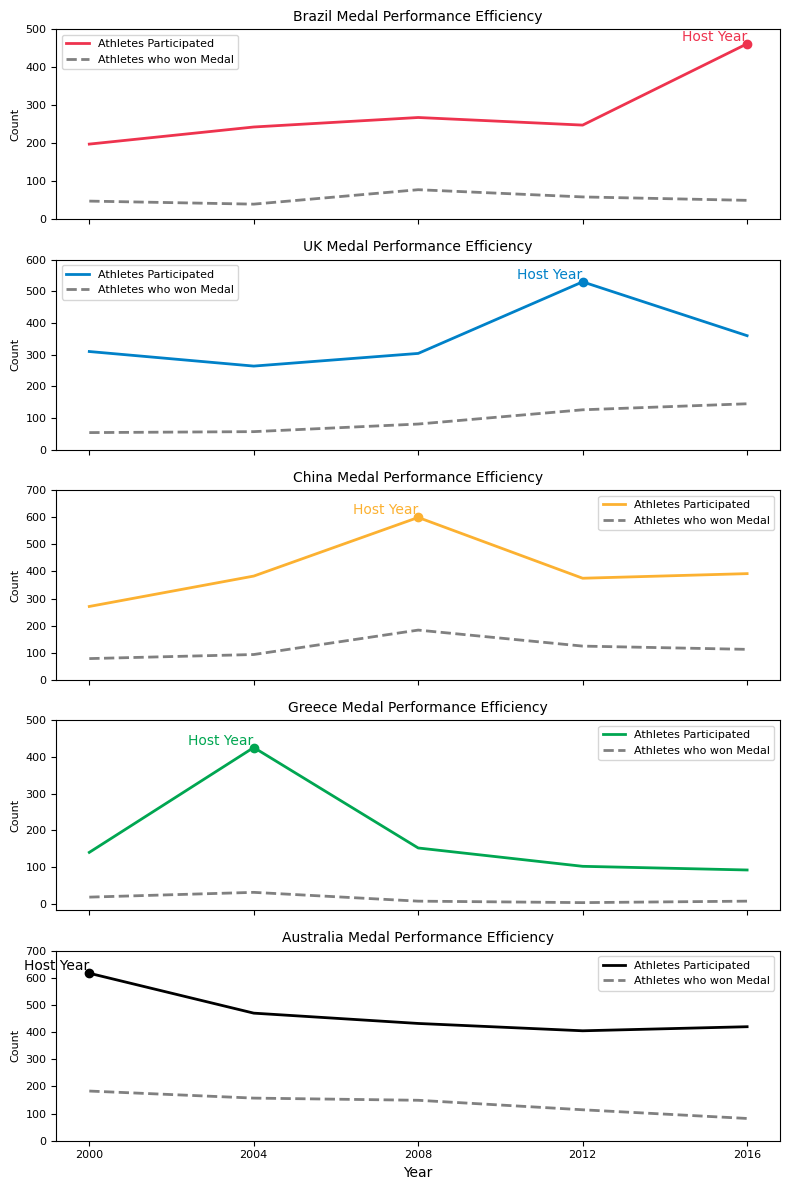

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the NOCs and years of interest
noc_of_interest = ['BRA', 'GBR', 'CHN', 'GRE', 'AUS']
region = ['Brazil', 'UK', 'China', 'Greece', 'Australia']
olympic_years = [2016, 2012, 2008, 2004, 2000]

# Filter the data by both NOC codes and Olympic years
filtered_data = medal_data[medal_data['NOC'].isin(noc_of_interest) & medal_data['Year'].isin(olympic_years)]

# Convert 'Year' to string for proper plotting
filtered_data['Year'] = filtered_data['Year'].astype(str)

# Ensure 'Medal_Total_Performance' exists in filtered data
if 'Medal_Total_Performance' not in filtered_data.columns:
    filtered_data['Medal_Total_Performance'] = 0

# Define Olympic colors
colors = {
    'BRA': '#EE334E',  
    'GBR': '#0081C8',  
    'CHN': '#FCB131',  
    'GRE': '#00A651',  
    'AUS': '#000000'   
}

# Create subplots
fig, axes = plt.subplots(nrows=len(noc_of_interest), ncols=1, figsize=(8, 12), sharex=True, sharey=False)

for ax, noc, region_name in zip(axes, noc_of_interest, region):  # Added region_name to loop
    noc_data = filtered_data[filtered_data['NOC'] == noc]
    
    # Plot Athlete Count with Olympic colors
    ax.plot(noc_data['Year'], noc_data['Athlete_Count'], color=colors[noc], linewidth=2, label='Athletes Participated')
    
    # Plot Medal Total Performance as dashed grey line
    ax.plot(noc_data['Year'], noc_data['Athlete_Medal_Count'], color='grey', linestyle='dashed', linewidth=2, label='Athletes who won Medal')
    
    # Highlight hosting year with marker and label
    for year in noc_data['Year']:
        if noc == 'BRA' and year == '2016':
            ax.scatter(year, noc_data[noc_data['Year'] == year]['Athlete_Count'], color=colors['BRA'], zorder=5)
            ax.text(year, noc_data[noc_data['Year'] == year]['Athlete_Count'].values[0], 'Host Year', 
                    color=colors['BRA'], fontsize=10, ha='right', va='bottom')
        elif noc == 'GBR' and year == '2012':
            ax.scatter(year, noc_data[noc_data['Year'] == year]['Athlete_Count'], color=colors['GBR'], zorder=5)
            ax.text(year, noc_data[noc_data['Year'] == year]['Athlete_Count'].values[0], 'Host Year', 
                    color=colors['GBR'], fontsize=10, ha='right', va='bottom')
        elif noc == 'CHN' and year == '2008':
            ax.scatter(year, noc_data[noc_data['Year'] == year]['Athlete_Count'], color=colors['CHN'], zorder=5)
            ax.text(year, noc_data[noc_data['Year'] == year]['Athlete_Count'].values[0], 'Host Year', 
                    color=colors['CHN'], fontsize=10, ha='right', va='bottom')
        elif noc == 'GRE' and year == '2004':
            ax.scatter(year, noc_data[noc_data['Year'] == year]['Athlete_Count'], color=colors['GRE'], zorder=5)
            ax.text(year, noc_data[noc_data['Year'] == year]['Athlete_Count'].values[0], 'Host Year', 
                    color=colors['GRE'], fontsize=10, ha='right', va='bottom')
        elif noc == 'AUS' and year == '2000':
            ax.scatter(year, noc_data[noc_data['Year'] == year]['Athlete_Count'], color=colors['AUS'], zorder=5)
            ax.text(year, noc_data[noc_data['Year'] == year]['Athlete_Count'].values[0], 'Host Year', 
                    color=colors['AUS'], fontsize=10, ha='right', va='bottom')
    
    # Set title using the region name
    ax.set_title(f'{region_name} Medal Performance Efficiency', fontsize=10)  # Title with region name
    ax.set_ylabel('Count', fontsize=8)
    ax.legend(fontsize=8)
    ax.tick_params(axis='both', labelsize=8)
    ax.yaxis.set_visible(True)  # Ensure Y-axis is visible for each chart

    y_min, y_max = ax.get_ylim()  # Get the current y-axis limits
    ax.set_yticks(np.arange(0, y_max + 100, 100))  # Set y-ticks every 10

# Set common x-axis label
axes[-1].set_xlabel('Year', fontsize=10)

# Adjust layout for clarity
plt.tight_layout()
plt.show()


In [35]:
# Decline in medal performance when a country hosts the Olympics
# More athletes from the host nation compete, but this does not necessarily mean more medals are won at the same rate.
# -> Lower Average Medal Conversion Rate

In [37]:
# Gold Medal Performance Growth Rate on Host Country
# USA 1996, AUS 2000, GRE 2004, CHN 2008, GBR 2012, BRA 2016
# List of NOCs to filter
host_region_years = [
    ('Brazil', 2012, 2016),
    ('UK', 2008, 2012),
    ('China', 2004, 2008),
    ('Greece', 2000, 2004),
    ('Australia', 1996, 2000)
]

# Create an empty list to store processed data
host_data_list = []

for region, non_host_year, host_year in host_region_years:
    
    # Extract data for Non-Host Year
    non_host_df = medal_data[(medal_data['Region'] == region) & (medal_data['Year'] == non_host_year)]
    
    # Extract data for Host Year
    host_df = medal_data[(medal_data['Region'] == region) & (medal_data['Year'] == host_year)]
    
    # Get Medal_Total_Performance values
    non_host_performance = non_host_df['Medal_Gold_Performance'].sum() if not non_host_df.empty else 0
    host_performance = host_df['Medal_Gold_Performance'].sum() if not host_df.empty else 0
    
    # Convert to percentage
    non_host_percentage = round(non_host_performance * 100, 2)
    host_percentage = round(host_performance * 100, 2)
    change_pp = round(host_percentage - non_host_percentage, 2)
    
    # Append to list
    host_data_list.append({'Country (Host Year)': f'{region} ({host_year})', 
                           'Non-Host': f'{non_host_percentage}%', 
                           'Host': f'{host_percentage}%', 
                           'Change (pp)': f'{change_pp} pp'})

# Convert list to DataFrame
host_data_gold_rate = pd.DataFrame(host_data_list)

host_data_gold_rate

,Country (Host Year),Non-Host,Host,Change (pp)
0,Brazil (2016),6.0%,8.0%,2.0 pp
1,UK (2012),10.0%,9.0%,-1.0 pp
2,China (2008),14.0%,12.0%,-2.0 pp
3,Greece (2004),3.0%,2.0%,-1.0 pp
4,Australia (2000),8.0%,10.0%,2.0 pp


/var/folders/yn/zzdysdkj6_z0rns53nqvdbvr0000gn/T/ipykernel_97465/1506625422.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Year'] = filtered_data['Year'].astype(str)


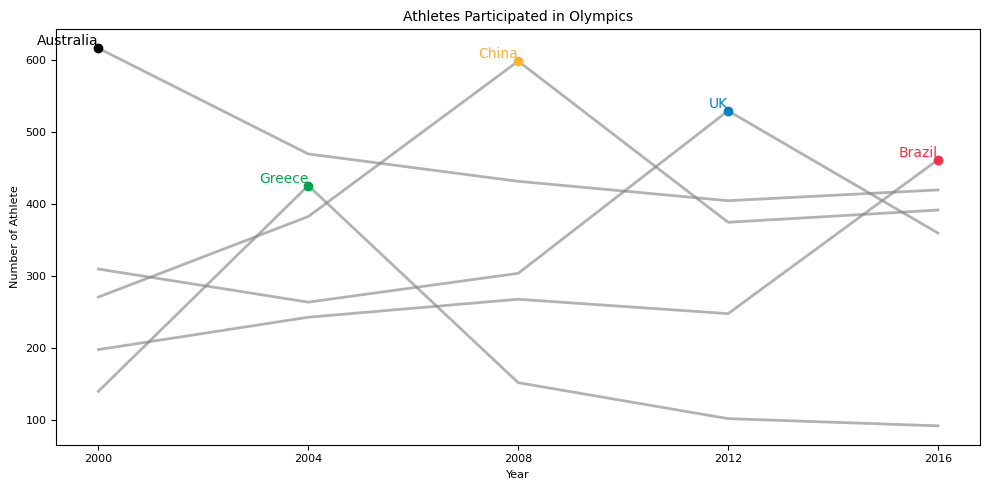

In [39]:
import matplotlib.pyplot as plt

noc_of_interest = ['BRA', 'GBR', 'CHN', 'GRE', 'AUS']
olympic_years = [2016, 2012, 2008, 2004, 2000]

# Filter the data by both NOC codes and Olympic years
filtered_data = medal_data[medal_data['NOC'].isin(noc_of_interest) & medal_data['Year'].isin(olympic_years)]

# Convert 'Year' to string if it is not already
filtered_data['Year'] = filtered_data['Year'].astype(str)

# Define the Olympic colors
colors = {
    'BRA': '#EE334E',  
    'GBR': '#0081C8',  
    'CHN': '#FCB131',  
    'GRE': '#00A651',  
    'AUS': '#000000'   
}

# Plotting
plt.figure(figsize=(10, 5))

# Loop through each NOC to create a line plot for Athlete_Count
for noc in noc_of_interest:
    noc_data = filtered_data[filtered_data['NOC'] == noc]
    
    # Plot the data for the country with a gray line and increase line width
    plt.plot(noc_data['Year'], noc_data['Athlete_Count'], color='gray', alpha=0.6, linewidth=2)
    
    # For hosting year, plot a colored marker and add the country name label
    for year in noc_data['Year']:
        if noc == 'BRA' and year == '2016':
            plt.scatter(year, noc_data[noc_data['Year'] == year]['Athlete_Count'], color=colors['BRA'], zorder=5)
            plt.text(year, noc_data[noc_data['Year'] == year]['Athlete_Count'].values[0], 'Brazil', 
                     color=colors['BRA'], fontsize=10, ha='right', va='bottom')
        elif noc == 'GBR' and year == '2012':
            plt.scatter(year, noc_data[noc_data['Year'] == year]['Athlete_Count'], color=colors['GBR'], zorder=5)
            plt.text(year, noc_data[noc_data['Year'] == year]['Athlete_Count'].values[0], 'UK', 
                     color=colors['GBR'], fontsize=10, ha='right', va='bottom')
        elif noc == 'CHN' and year == '2008':
            plt.scatter(year, noc_data[noc_data['Year'] == year]['Athlete_Count'], color=colors['CHN'], zorder=5)
            plt.text(year, noc_data[noc_data['Year'] == year]['Athlete_Count'].values[0], 'China', 
                     color=colors['CHN'], fontsize=10, ha='right', va='bottom')
        elif noc == 'GRE' and year == '2004':
            plt.scatter(year, noc_data[noc_data['Year'] == year]['Athlete_Count'], color=colors['GRE'], zorder=5)
            plt.text(year, noc_data[noc_data['Year'] == year]['Athlete_Count'].values[0], 'Greece', 
                     color=colors['GRE'], fontsize=10, ha='right', va='bottom')
        elif noc == 'AUS' and year == '2000':
            plt.scatter(year, noc_data[noc_data['Year'] == year]['Athlete_Count'], color=colors['AUS'], zorder=5)
            plt.text(year, noc_data[noc_data['Year'] == year]['Athlete_Count'].values[0], 'Australia', 
                     color=colors['AUS'], fontsize=10, ha='right', va='bottom')

# Adding labels and title with smaller font sizes for x and y axes
plt.xlabel('Year', fontsize=8)
plt.ylabel('Number of Athlete', fontsize=8)
plt.title('Athletes Participated in Olympics', fontsize=10)

# Adjust tick label size
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()

In [41]:
olympic_podium=pd.read_csv('podium_1996-2016.csv')

In [43]:
filtered_df = olympic_podium[olympic_podium['NOC'].isin(['USA', 'AUS', 'GRE', 'CHN', 'GBR', 'BRA'])]

# Create a new DataFrame by grouping and counting the medals
olympic_podium_agg = (filtered_df.groupby(['Year', 'NOC', 'region', 'City', 'Medal'])
                       .size()
                       .unstack(fill_value=0)
                       .reset_index())

# Rename columns for clarity
olympic_podium_agg = olympic_podium_agg.rename(columns={'Gold': 'Gold', 'Silver': 'Silver', 'Bronze': 'Bronze'})

# Rename 'region' column to 'Region'
olympic_podium_agg = olympic_podium_agg.rename(columns={'region': 'Region'})

# Reorder the columns to match the requested structure
olympic_podium_agg = olympic_podium_agg[['Year', 'NOC', 'Region', 'City', 'Gold', 'Silver', 'Bronze']]

# Add the Total column as the sum of Gold, Silver, and Bronze
olympic_podium_agg['Total'] = olympic_podium_agg[['Gold', 'Silver', 'Bronze']].sum(axis=1)
olympic_podium_agg['Year'] = olympic_podium_agg['Year'].astype(str)

olympic_podium_agg.head(10)

Medal,Year,NOC,Region,City,Gold,Silver,Bronze,Total
0,1996,AUS,Australia,Atlanta,9,9,23,41
1,1996,BRA,Brazil,Atlanta,3,3,9,15
2,1996,CHN,China,Atlanta,16,22,12,50
3,1996,GBR,UK,Atlanta,1,8,6,15
4,1996,GRE,Greece,Atlanta,4,4,0,8
5,1996,USA,USA,Atlanta,44,32,25,101
6,2000,AUS,Australia,Sydney,16,25,17,58
7,2000,BRA,Brazil,Sydney,0,6,6,12
8,2000,CHN,China,Sydney,28,16,14,58
9,2000,GBR,UK,Sydney,11,10,7,28


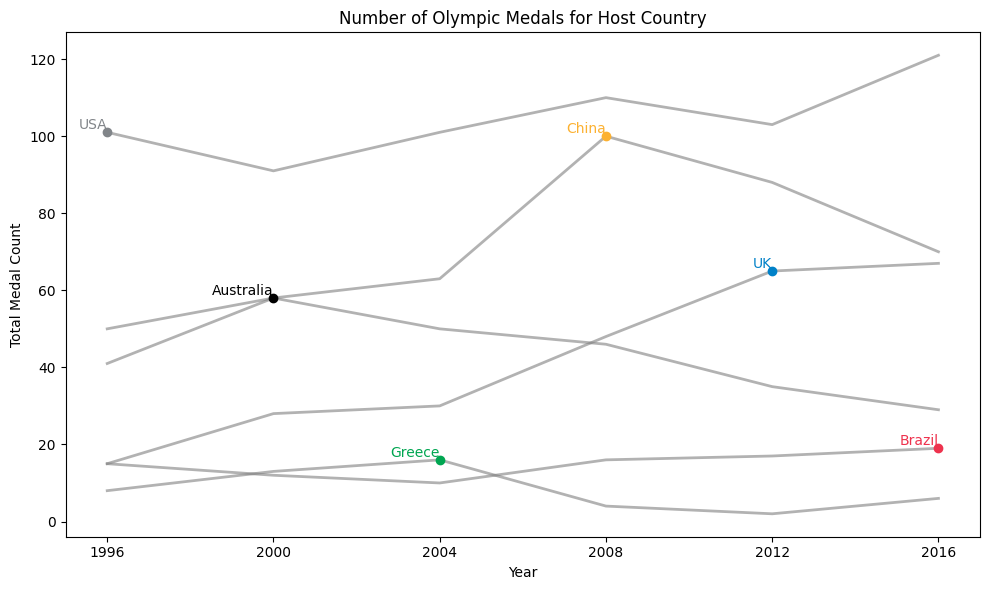

In [45]:
hosting_info = {
    1996: 'USA', 
    2000: 'AUS', 
    2004: 'GRE', 
    2008: 'CHN', 
    2012: 'GBR', 
    2016: 'BRA'
}

colors = {
    'BRA': '#EE334E',  
    'GBR': '#0081C8',  
    'CHN': '#FCB131',  
    'GRE': '#00A651',  
    'AUS': '#000000',
    'USA': '#818589'
}

# Plot the data for each NOC (country) from the original DataFrame
plt.figure(figsize=(10, 6))

# Iterate over each NOC
for noc in olympic_podium_agg['NOC'].unique():
    # Filter the data for the specific NOC
    noc_data = olympic_podium_agg[olympic_podium_agg['NOC'] == noc]
    
    # Plot the data for the country with a gray line and increase line width
    plt.plot(noc_data['Year'], noc_data['Total'], color='grey', alpha=0.6, linewidth=2)

    # For hosting year, plot a colored marker and add the country name label
    for year in noc_data['Year']:
        if noc == 'BRA' and year == '2016':
            plt.scatter(year, noc_data[noc_data['Year'] == year]['Total'], color=colors['BRA'], zorder=5)
            plt.text(year, noc_data[noc_data['Year'] == year]['Total'].values[0], 'Brazil', color=colors['BRA'], fontsize=10, ha='right', va='bottom')
        elif noc == 'GBR' and year == '2012':
            plt.scatter(year, noc_data[noc_data['Year'] == year]['Total'], color=colors['GBR'], zorder=5)
            plt.text(year, noc_data[noc_data['Year'] == year]['Total'].values[0], 'UK', color=colors['GBR'], fontsize=10, ha='right', va='bottom')
        elif noc == 'CHN' and year == '2008':
            plt.scatter(year, noc_data[noc_data['Year'] == year]['Total'], color=colors['CHN'], zorder=5)
            plt.text(year, noc_data[noc_data['Year'] == year]['Total'].values[0], 'China', color=colors['CHN'], fontsize=10, ha='right', va='bottom')
        elif noc == 'GRE' and year == '2004':
            plt.scatter(year, noc_data[noc_data['Year'] == year]['Total'], color=colors['GRE'], zorder=5)
            plt.text(year, noc_data[noc_data['Year'] == year]['Total'].values[0], 'Greece', color=colors['GRE'], fontsize=10, ha='right', va='bottom')
        elif noc == 'AUS' and year == '2000':
            plt.scatter(year, noc_data[noc_data['Year'] == year]['Total'], color=colors['AUS'], zorder=5)
            plt.text(year, noc_data[noc_data['Year'] == year]['Total'].values[0], 'Australia', color=colors['AUS'], fontsize=10, ha='right', va='bottom')
        elif noc == 'USA' and year == '1996':
            plt.scatter(year, noc_data[noc_data['Year'] == year]['Total'], color=colors['USA'], zorder=5)
            plt.text(year, noc_data[noc_data['Year'] == year]['Total'].values[0], 'USA', color=colors['USA'], fontsize=10, ha='right', va='bottom')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Total Medal Count')
plt.title('Number of Olympic Medals for Host Country')

plt.tight_layout()
plt.show()

In [47]:
aus_m = olympic_podium_agg[olympic_podium_agg['Region'] == 'Australia']
aus_m

Medal,Year,NOC,Region,City,Gold,Silver,Bronze,Total
0,1996,AUS,Australia,Atlanta,9,9,23,41
6,2000,AUS,Australia,Sydney,16,25,17,58
12,2004,AUS,Australia,Athens,17,16,17,50
18,2008,AUS,Australia,Beijing,14,15,17,46
24,2012,AUS,Australia,London,7,16,12,35
30,2016,AUS,Australia,Rio de Janeiro,8,11,10,29


In [49]:
greece_m = olympic_podium_agg[olympic_podium_agg['Region'] == 'Greece']
greece_m

Medal,Year,NOC,Region,City,Gold,Silver,Bronze,Total
4,1996,GRE,Greece,Atlanta,4,4,0,8
10,2000,GRE,Greece,Sydney,4,6,3,13
16,2004,GRE,Greece,Athens,6,6,4,16
22,2008,GRE,Greece,Beijing,0,2,2,4
28,2012,GRE,Greece,London,0,0,2,2
34,2016,GRE,Greece,Rio de Janeiro,3,1,2,6


In [51]:
china_m = olympic_podium_agg[olympic_podium_agg['NOC'] == 'CHN']
china_m

Medal,Year,NOC,Region,City,Gold,Silver,Bronze,Total
2,1996,CHN,China,Atlanta,16,22,12,50
8,2000,CHN,China,Sydney,28,16,14,58
14,2004,CHN,China,Athens,32,17,14,63
20,2008,CHN,China,Beijing,51,21,28,100
26,2012,CHN,China,London,38,27,23,88
32,2016,CHN,China,Rio de Janeiro,26,18,26,70


In [53]:
import pandas as pd

# Assuming olympic_podium_agg is your original DataFrame

# List of countries of interest
noc_of_interest = ['BRA', 'GBR', 'CHN', 'GRE', 'AUS']

# Define the host years and non-host years
host_region_years = [
    ('Brazil', "2012", "2016"),
    ('UK', "2008", "2012"),
    ('China', "2004", "2008"),
    ('Greece', "2000", "2004"),
    ('Australia', "1996", "2000")
]

# Step 1: Filter the olympic_podium_agg DataFrame for noc_of_interest
olympic_podium_filtered = olympic_podium_agg[olympic_podium_agg['NOC'].isin(noc_of_interest)]

# Step 2: Create a list to hold the data for the new DataFrame
host_change_data = []

# Step 3: Loop through each region and extract the relevant data
for region, non_host_year, host_year in host_region_years:
    # Filter data for the non-host year
    non_host_data = olympic_podium_filtered[(olympic_podium_filtered['Year'] == non_host_year) &
                                           (olympic_podium_filtered['Region'] == region)]
    non_host_total = non_host_data['Total'].sum()

    # Filter data for the host year
    host_data = olympic_podium_filtered[(olympic_podium_filtered['Year'] == host_year) &
                                       (olympic_podium_filtered['Region'] == region)]
    host_total = host_data['Total'].sum()

    # Calculate the change percentage
    if non_host_total != 0:
        change_percent = round((host_total - non_host_total) / non_host_total * 100, 0)
    else:
        change_percent = 0

    # Append the region data to the host_change_data list
    host_change_data.append({
        'Country (Host Year)': f'{region} ({host_year})',
        'Non-Host': non_host_total,
        'Host': host_total,
        'Change (%)': f'{change_percent}%'
    })

# Step 4: Create the new DataFrame
olympic_podium_host_change = pd.DataFrame(host_change_data)

# Show the new DataFrame
olympic_podium_host_change


,Country (Host Year),Non-Host,Host,Change (%)
0,Brazil (2016),17,19,12.0%
1,UK (2012),48,65,35.0%
2,China (2008),63,100,59.0%
3,Greece (2004),13,16,23.0%
4,Australia (2000),41,58,41.0%


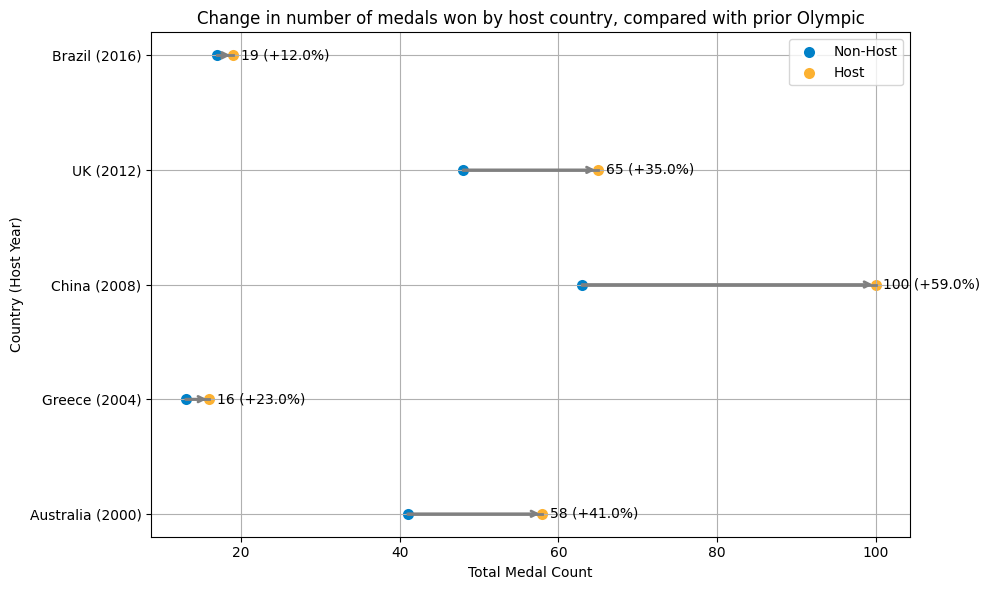

In [55]:
import seaborn as sns
df = pd.DataFrame(olympic_podium_host_change)

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Create a seaborn scatterplot for the dumbbell chart
sns.scatterplot(x='Non-Host', y='Country (Host Year)', data=df, color='#0081C8', s=100, label='Non-Host', edgecolor='w', linewidth=2)
sns.scatterplot(x='Host', y='Country (Host Year)', data=df, color='#FCB131', s=100, label='Host', edgecolor='w', linewidth=2)

# Add lines to connect Non-Host and Host points
for index, row in df.iterrows():
    # Draw the line
    plt.plot([row['Non-Host'], row['Host']], [row['Country (Host Year)'], row['Country (Host Year)']], color='gray', lw=2)

    # Add an arrow to indicate the direction of change
    plt.annotate('', xy=(row['Host'], index), xytext=(row['Non-Host'], index),
                 arrowprops=dict(arrowstyle='->', color='gray', lw=2, shrinkA=0))

# Add text labels for Change (%) in the format "Host (+Change %)"
for index, row in df.iterrows():
    label = f"{row['Host']} (+{row['Change (%)']})"
    plt.text(row['Host'] + 1, row['Country (Host Year)'], label, ha='left', va='center', fontsize=10)

# Customize plot
plt.title('Change in number of medals won by host country, compared with prior Olympic')
plt.xlabel('Total Medal Count')
plt.ylabel('Country (Host Year)')
plt.grid(True)
plt.tight_layout()
plt.savefig("Host_change_medals_won.png", format='png', dpi=300)

# Show the plot
plt.show()

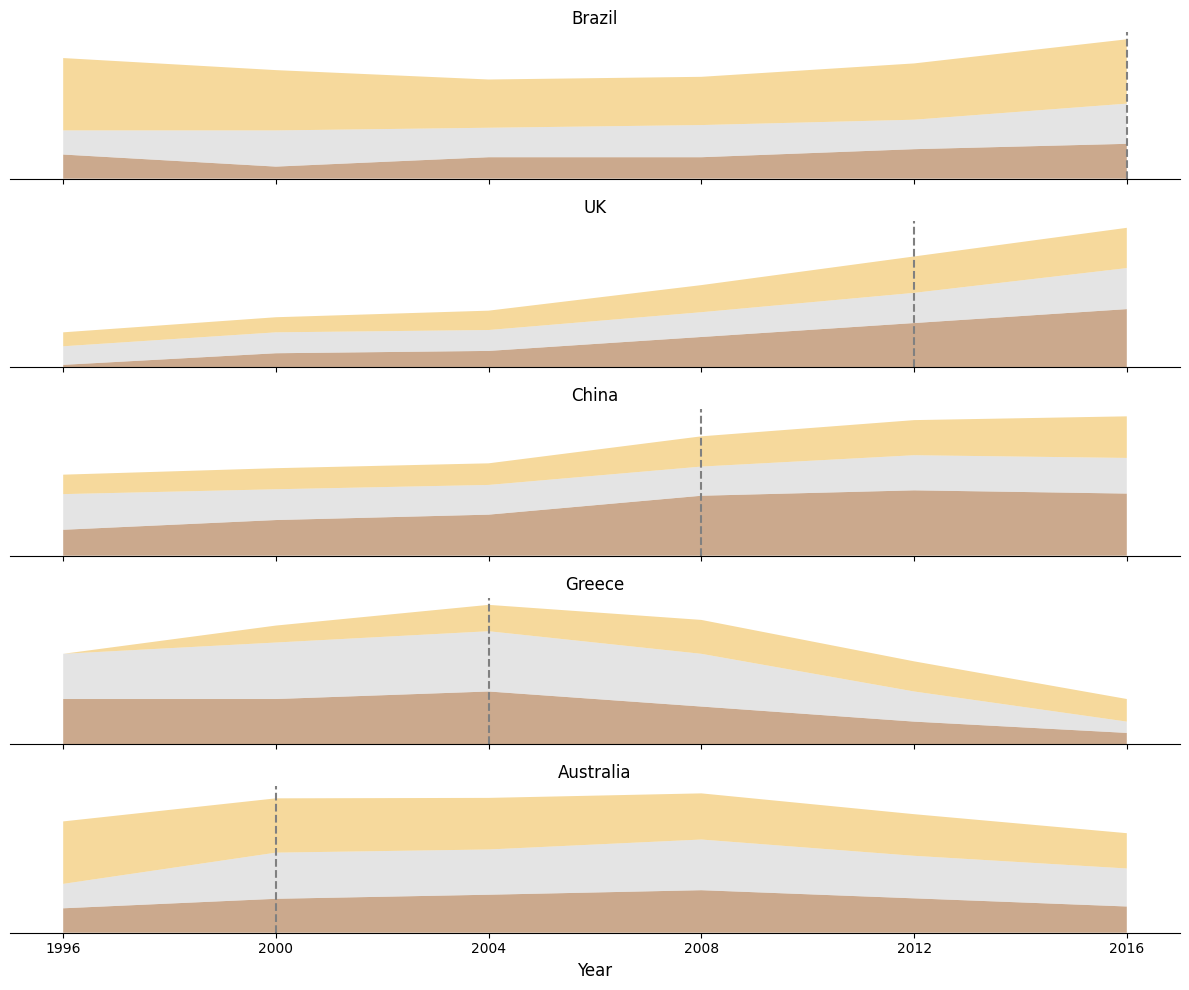

In [95]:
df2 = pd.DataFrame(olympic_podium_agg)

# List of NOCs you want to focus on
noc_of_interest = ['BRA', 'GBR', 'CHN', 'GRE', 'AUS']

# Colors for Gold, Silver, and Bronze
colors = ['#a97142', 'lightgray', '#f0c05a']

# Hosting years information
hosting_info = { 
    "2000": 'AUS', 
    "2004": 'GRE', 
    "2008": 'CHN', 
    "2012": 'GBR', 
    "2016": 'BRA'
}

# Filter data based on NOCs of interest
filtered_data = df2[df2['NOC'].isin(noc_of_interest)]

# Now, we need to create a stacked plot for each country
# We will group the data by Region and Year
filtered_data = filtered_data[['Year', 'NOC', 'Region', 'Gold', 'Silver', 'Bronze']]

# Sort the data by Region and Year
filtered_data = filtered_data.sort_values(by=['Region', 'Year'])

# Define a function for stacked ridgelines
def plot_ridgeline_chart(df2, noc_of_interest, colors, hosting_info, window_size=3):
    # Group data by Region and Year and aggregate Gold, Silver, and Bronze
    plot_data = []

    for noc in noc_of_interest:
        noc_data = df2[df2['NOC'] == noc]
        years = noc_data['Year'].values
        gold = noc_data['Gold'].values
        silver = noc_data['Silver'].values
        bronze = noc_data['Bronze'].values
        
        # Smooth the data using pandas rolling window (Simple Moving Average)
        gold_smooth = pd.Series(gold).rolling(window=window_size, min_periods=1).mean()
        silver_smooth = pd.Series(silver).rolling(window=window_size, min_periods=1).mean()
        bronze_smooth = pd.Series(bronze).rolling(window=window_size, min_periods=1).mean()
        
        # Stack data: Gold, Silver, and Bronze (smoothed)
        plot_data.append(np.stack([gold_smooth, silver_smooth, bronze_smooth], axis=0))
        
    # Plot the ridgeline chart
    fig, axes = plt.subplots(len(noc_of_interest), 1, figsize=(12, 10), sharex=True, sharey=False)
    
    for ax, noc, data in zip(axes, noc_of_interest, plot_data):
        # Create a stacked area chart on each subplot with custom colors
        ax.stackplot(years, data, labels=['Gold', 'Silver', 'Bronze'], colors=colors, alpha=0.6)
        
        # Add a vertical line for the hosting year
        for year in years:
            if str(year) in hosting_info.keys() and hosting_info[str(year)] == noc:
                ax.axvline(x=year, color='grey', linestyle='--', label=f'Hosting Year ({year})')
        
        # Remove the frame and y-axis
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])  # Hide the y-axis ticks
        
        # Set title and label
        ax.set_title(f'{df2[df2["NOC"] == noc]["Region"].values[0]}', fontsize=12)
        # ax.set_ylabel('Medals', fontsize=10)
        
    # Set the x-axis label
    ax.set_xlabel('Year', fontsize=12)
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_ridgeline_chart(filtered_data, noc_of_interest, colors, hosting_info)